# AT&T SPAM DETECTOR
This project is for [JEDHA](https://www.jedha.co/) Data Science Full-Stack Bootcamp.


## Install and import packages

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#pip install torchinfo

In [1]:
#pip install transformers datasets

In [2]:
#pip install transformers[torch]

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, GRU, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import random
from wordcloud import WordCloud

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from torchinfo import summary
from transformers import pipeline


In [6]:
df = pd.read_csv("spam.csv", encoding = 'ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Let's drop the unnamed empty columns:

In [7]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)

## PART 1: EDA

### Distribution of the target variable:

(array([4825.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         747.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

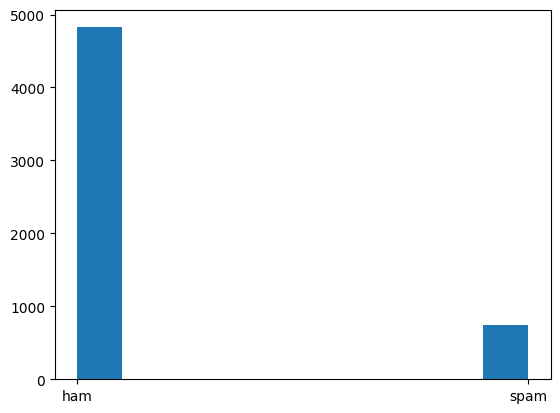

In [8]:
plt.hist(df["v1"])

- As we can see the dataset is highly imbalanced, with a much-lower appearance of the category spam.
- we should keep this in mind when checking the metrics score for our models.

#### Word Cloud on the most frequent words of each category

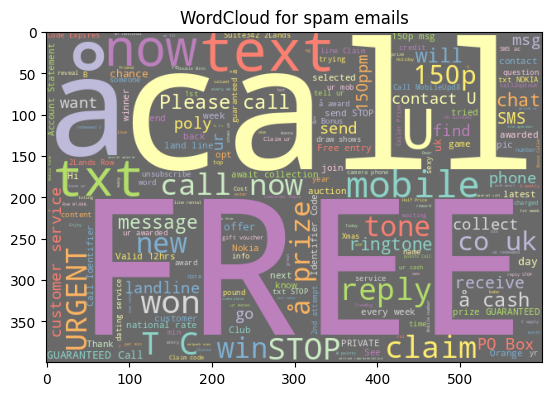

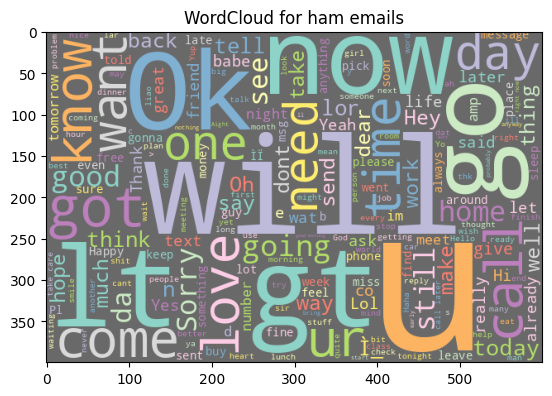

In [9]:
for i in set(df['v1']):
    #print("WordCloud for", i)
    words = ''
    for document in df[df['v1'] == i]['v2']:
        words += document + ' '
    wordcloud = WordCloud(width=600, height=400, background_color='#696969', colormap='Set3').generate(words)
    plt.imshow(wordcloud)
    plt.title("WordCloud for {} emails".format(i))
    plt.show()

The results from wordclouds are quite intiutive with spam messages frequently containing words like "free, prize, receive, call" as one might expect.


Encoding the target variable:

In [10]:
target_map = {"ham": 0 ,"spam" : 1}
df['target'] = df["v1"].map(target_map)
df.head()

,v1,v2,target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Train - Validation - Test Split
Since the neural networks use a validation dataset to improve the model performance, we will use a three-way split so that we will be able to test the final models on a data it has not seen during the training.

In [11]:
df_train_val, df_test, Y_train_val, Y_test = train_test_split(
    df['v2'], df['target'], test_size=0.1, random_state = 123)

df_train, df_val, Y_train, Y_val = train_test_split(
    df_train_val, Y_train_val, test_size=0.33, random_state = 123)

print("Shape of train set is", df_train.shape)
print("Shape of validation set is", df_val.shape)
print("Shape of test set is", df_test.shape)

Shape of train set is (3359,)
Shape of validation set is (1655,)
Shape of test set is (558,)


## PART 2: Text Classification with Neural Networks
## Baseline ANN

For the deep learning models, we have several options for converting text to integers:
- we can use sklearn's CountVectorizer or Tfidf Vectorizer for bag-of-words approaches as we do in the classical ML models
- we can use word embeddings
    
In this notebook, I will show both.

### ANN with Tfidf Vectorization
First, let's convert our text data to integers with the help of Tfidf vectorizer.

In [12]:
vectorizer = TfidfVectorizer(decode_error='ignore')
X_train = vectorizer.fit_transform(df_train)
X_val, X_test = vectorizer.transform(df_val), vectorizer.transform(df_test)

X_train, X_val, X_test = X_train.toarray(), X_val.toarray(), X_test.toarray()

X_train.shape

(3359, 6744)

Now, let's build a simple neural network:

In [13]:
D = X_train.shape[1]

# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid will be included in loss function

model_1 = Model(i, x)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6744)]            0         
                                                                 
 dense (Dense)               (None, 1)                 6745      
                                                                 
Total params: 6745 (26.35 KB)
Trainable params: 6745 (26.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Notice that I didn't design a sigmoid activation function for the final dense layer. The reason is I wanted to keep the output in form of logits and instead incorporate it to the loss function by BinaryCrossentropy(from_logits=True) parameter.

In [14]:
model_1.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

r = model_1.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=80,
    batch_size=128,
)

Epoch 1/80
27/27 [==============================] - 4s 55ms/step - loss: 0.5762 - accuracy: 0.8628 - val_loss: 0.4551 - val_accuracy: 0.8671
Epoch 2/80
27/27 [==============================] - 0s 15ms/step - loss: 0.3921 - accuracy: 0.8628 - val_loss: 0.3358 - val_accuracy: 0.8695
Epoch 3/80
27/27 [==============================] - 0s 15ms/step - loss: 0.2974 - accuracy: 0.8705 - val_loss: 0.2703 - val_accuracy: 0.8834
Epoch 4/80
27/27 [==============================] - 0s 16ms/step - loss: 0.2409 - accuracy: 0.8931 - val_loss: 0.2279 - val_accuracy: 0.9033
Epoch 5/80
27/27 [==============================] - 0s 15ms/step - loss: 0.2022 - accuracy: 0.9166 - val_loss: 0.1980 - val_accuracy: 0.9202
Epoch 6/80
27/27 [==============================] - 0s 11ms/step - loss: 0.1736 - accuracy: 0.9318 - val_loss: 0.1752 - val_accuracy: 0.9305
Epoch 7/80
27/27 [==============================] - 0s 15ms/step - loss: 0.1516 - accuracy: 0.9443 - val_loss: 0.1573 - val_accuracy: 0.9408
Epoch 8/80
27

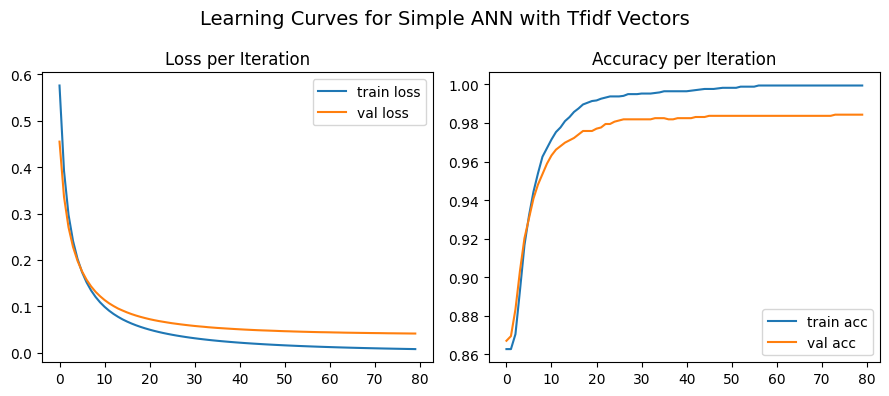

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for Simple ANN with Tfidf Vectors', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

The model performance starts to converge after the 40th epoch especially for the validation set and we already get quite decent results with this simple neural network.

Since the target variable has a very imbalanced distribution between ham and spam categories, f1-score would be a better metric than the accuracy for assessing the model performance.

In [16]:
P_train = ((model_1.predict(X_train) > 0) * 1.0).flatten()
P_val = ((model_1.predict(X_val) > 0) * 1.0).flatten()
P_test = ((model_1.predict(X_test) > 0) * 1.0).flatten()


print("Train F1:", f1_score(Y_train, P_train))
print("Val F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

18/18 [==============================] - 0s 4ms/step
Train F1: 0.998914223669924
Val F1: 0.9526066350710902
Test F1: 0.9180327868852458


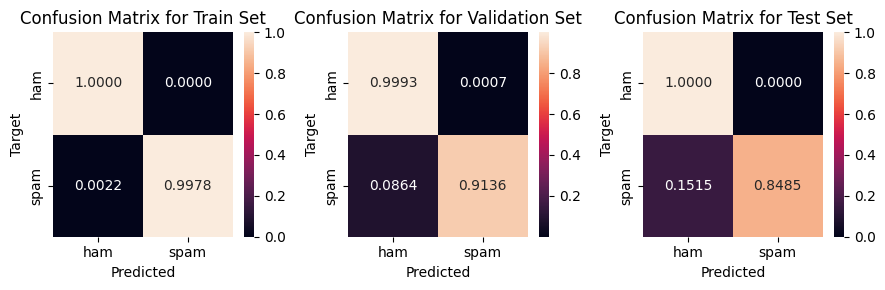

In [17]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

def plot_cm(ax, cm, title):
  classes = ['ham', 'spam']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  sns.heatmap(df_cm, annot=True, fmt='.4f', ax = ax)
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")
  ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

Visualizing normalized confustion matrices for all three sets, we can actually compare the recall performances of the model on these sets.
- The false negative rate is below 1% in the train set, in other words, less than 1% of the spam messages wrongly labelled as ham by the model.
- The rate of false negative is near 9% in the validation set, that is, the model correctly identifies 91% of the spam messages but misclassifies 9% of them as 'ham'.
- When we use it for the test set, this rate increases to 15% with 85% of the spam messages identified as such.
- In all 3 sets, the model achieves a nearly perfect identification of the ham messages.

In [18]:
model_1.save('model_1.h5')

### ANN with Increased Complexity
In this section I will increase the complexity of ANN by:
- first using word embeddings for vectorization rather than tfidf scores.
- then increasing the number of dense layers and playing with the number of hidden units

First let's create an instance of Tensorflow's Tokenizer class to convert our text data to sequences. Notice that despite being called tokenizer, this class actually both convert text into tokens and then represent them as sequences of integers.

In [19]:
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_val = tokenizer.texts_to_sequences(df_val)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [20]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 6929 unique tokens.


To be able to use RNN, we must make sure we're dealing with sequences of the same length. Therefore we will apply padding to our sequences. We will train our pad_sequences object on the train data and then use it to transform validation and test data.

This means any sequence in the validation and test set whose length is longer than the sequence length of the padded train set will be automatically truncated.

In [21]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

data_val = pad_sequences(sequences_val, maxlen=T)
data_test = pad_sequences(sequences_test, maxlen=T) #notice we set the maxlen to T.
print('Shape of data test tensor:', data_test.shape)

Shape of data train tensor: (3359, 189)
Shape of data test tensor: (558, 189)


Model building:

In [28]:
# I pick the embedding dimension as 30.
D = 30

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index (in the embedding matrix) starts from 1 and not 0 as the index 0 is reserved for padding.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dense(32, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
#x = GlobalMaxPooling1D()(x) I also tried this option but I obtained better performance with GlobalAveragePooling
x = Dense(1)(x)

model_2 = Model(i, x)

Since I designed a more complex model with more layers and hidden units that I expect it to learn faster, I will train 30 epochs rather than 60, which I believe will be sufficient.

In [29]:
model_2.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

r = model_2.fit(
    data_train, Y_train,
    validation_data=(data_test, Y_test),
    epochs=30,
    batch_size=256,
)

Epoch 1/30
14/14 [==============================] - 4s 221ms/step - loss: 0.5184 - accuracy: 0.8628 - val_loss: 0.3536 - val_accuracy: 0.8817
Epoch 2/30
14/14 [==============================] - 2s 138ms/step - loss: 0.3828 - accuracy: 0.8628 - val_loss: 0.3302 - val_accuracy: 0.8817
Epoch 3/30
14/14 [==============================] - 2s 108ms/step - loss: 0.3143 - accuracy: 0.8628 - val_loss: 0.2265 - val_accuracy: 0.8835
Epoch 4/30
14/14 [==============================] - 1s 94ms/step - loss: 0.1725 - accuracy: 0.9169 - val_loss: 0.1132 - val_accuracy: 0.9570
Epoch 5/30
14/14 [==============================] - 1s 98ms/step - loss: 0.0817 - accuracy: 0.9711 - val_loss: 0.0749 - val_accuracy: 0.9713
Epoch 6/30
14/14 [==============================] - 1s 71ms/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 0.0627 - val_accuracy: 0.9749
Epoch 7/30
14/14 [==============================] - 1s 68ms/step - loss: 0.0374 - accuracy: 0.9863 - val_loss: 0.0585 - val_accuracy: 0.9749
Epoch 8/30

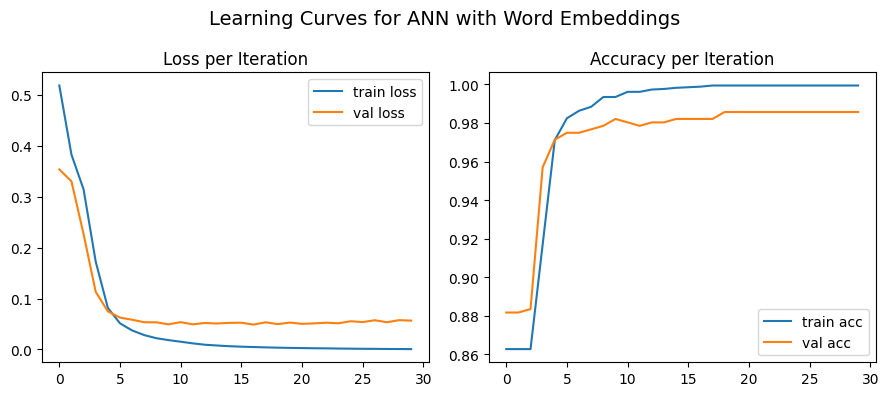

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for ANN with Word Embeddings', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

By looking at the learning curves, we can say that the model already achieved a decent performance after the fifth epoch and training it further did not improve the performance much afterwards. As expected, it performed better on the train set than validation set.

In [31]:
P_train = ((model_2.predict(data_train) > 0) * 1.0).flatten()
P_val = ((model_2.predict(data_val) > 0) * 1.0).flatten()
P_test = ((model_2.predict(data_test) > 0) * 1.0).flatten()

print("Train F1:", f1_score(Y_train, P_train))
print("Train F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

18/18 [==============================] - 0s 2ms/step
Train F1: 1.0
Train F1: 0.9627906976744187
Test F1: 0.9354838709677419


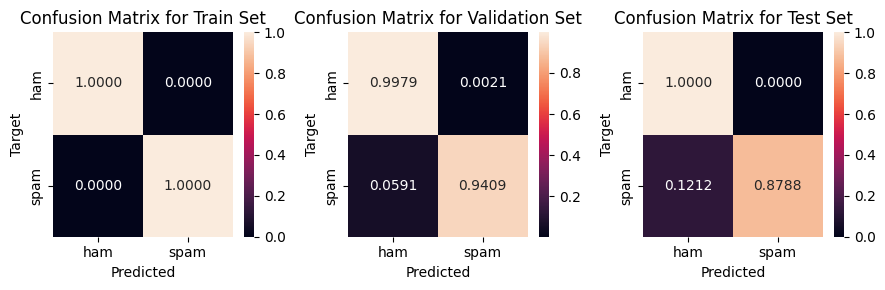

In [32]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

- As an improvement from the simple ANN model, this more complex version achieves the perfect score on the train set.
- The rate of false negatives is 6% in the validation set, that is, the model correctly identifies 94% of the spam messages but misclassifies 6% of them as 'ham'.
- When we use it for the test set, this rate increases to 12% with 88% of the spam messages correctly classified.
- In all 3 sets, the model achieves a nearly perfect identification of the ham messages.

In [33]:
model_2.save('model_2.h5')

## Recurrent Neural Networks (RNN)
Another option is instead of relying on bag-of-word representations of the words, to take the word orders, therefore, the contexts in to account.

In this section I will train two recurrent neural network models:
- LSTM
- Bidirectional GRU

### LSTM

In [74]:
i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)

LSTM_ = Model(i, x)


In [75]:
LSTM_.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

r = LSTM_.fit(
    data_train, Y_train,
    validation_data=(data_test, Y_test),
    epochs=30,
    batch_size=128,
)

Epoch 1/30
27/27 [==============================] - 5s 124ms/step - loss: 0.4290 - accuracy: 0.8628 - val_loss: 0.3158 - val_accuracy: 0.8817
Epoch 2/30
27/27 [==============================] - 3s 95ms/step - loss: 0.2140 - accuracy: 0.8854 - val_loss: 0.1058 - val_accuracy: 0.9695
Epoch 3/30
27/27 [==============================] - 3s 122ms/step - loss: 0.0450 - accuracy: 0.9896 - val_loss: 0.0441 - val_accuracy: 0.9875
Epoch 4/30
27/27 [==============================] - 3s 91ms/step - loss: 0.0118 - accuracy: 0.9970 - val_loss: 0.0393 - val_accuracy: 0.9857
Epoch 5/30
27/27 [==============================] - 2s 74ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0867 - val_accuracy: 0.9803
Epoch 6/30
27/27 [==============================] - 2s 80ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0554 - val_accuracy: 0.9892
Epoch 7/30
27/27 [==============================] - 2s 68ms/step - loss: 7.4130e-04 - accuracy: 1.0000 - val_loss: 0.0627 - val_accuracy: 0.9892
Epoch 8

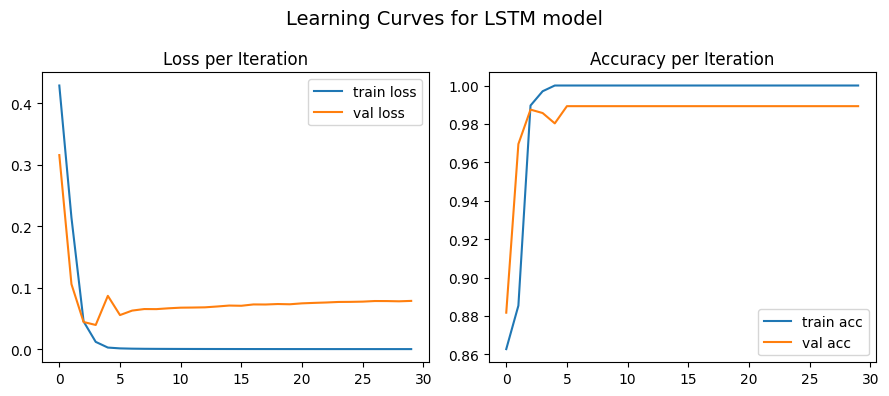

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for LSTM model', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

LSTM model also starts converging even after the 5th epoch and we can actually see the validation loss starting to increase after the 10th epoch. This implies some overfitting. Yet, this doesn't seem to seriously impair model's accuracy according to the second graph.

Let's check the f1-scores.

In [77]:
P_train = ((LSTM_.predict(data_train) > 0) * 1.0).flatten()
P_val = ((LSTM_.predict(data_val) > 0) * 1.0).flatten()
P_test = ((LSTM_.predict(data_test) > 0) * 1.0).flatten()


print("Train F1:", f1_score(Y_train, P_train))
print("Val F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

18/18 [==============================] - 0s 4ms/step
Train F1: 1.0
Val F1: 0.9579439252336448
Test F1: 0.9523809523809523


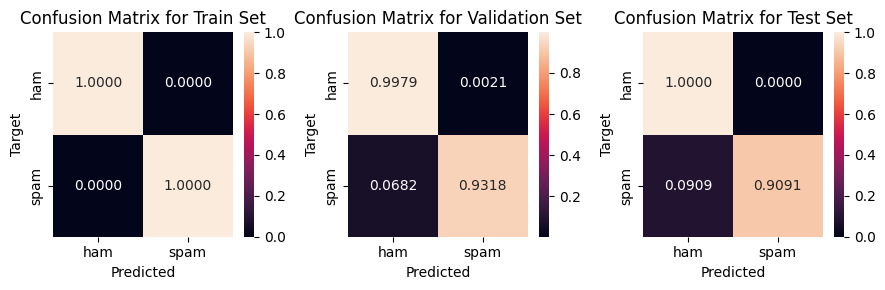

In [78]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

- Interestingly, the LSTM model predicts a higher number of False Positives in the validation set than our previous model, with recall score declining from 0.95 to 0.93. This might indeed be due to some overfitting on the train data.
- However, when we use it for the test set, LSTM clearly outperforms the previous model, with 91% of the spam messages correctly classified. (0.88 was the recall score of the previous model).
- With this trade-off between validation & test set performances, it is hard to say that one model has a clear advantage over the other.

In [80]:
LSTM_.save('LSTM_.h5')

### GRU

In [86]:
i = Input(shape=(T,))

x = Embedding(V + 1, D)(i)
x = Bidirectional(GRU(32, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1)(x)

GRU_ = Model(i, x)


In [87]:
GRU_.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

r = GRU_.fit(
    data_train, Y_train,
    validation_data=(data_test, Y_test),
    epochs=30,
    batch_size=128,
)

Epoch 1/30
27/27 [==============================] - 9s 189ms/step - loss: 0.3143 - accuracy: 0.8857 - val_loss: 0.0520 - val_accuracy: 0.9803
Epoch 2/30
27/27 [==============================] - 4s 141ms/step - loss: 0.0333 - accuracy: 0.9917 - val_loss: 0.0366 - val_accuracy: 0.9892
Epoch 3/30
27/27 [==============================] - 4s 147ms/step - loss: 0.0101 - accuracy: 0.9955 - val_loss: 0.0303 - val_accuracy: 0.9839
Epoch 4/30
27/27 [==============================] - 4s 135ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0321 - val_accuracy: 0.9875
Epoch 5/30
27/27 [==============================] - 5s 184ms/step - loss: 5.8186e-04 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9910
Epoch 6/30
27/27 [==============================] - 2s 80ms/step - loss: 2.9413e-04 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9910
Epoch 7/30
27/27 [==============================] - 2s 65ms/step - loss: 2.0788e-04 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9

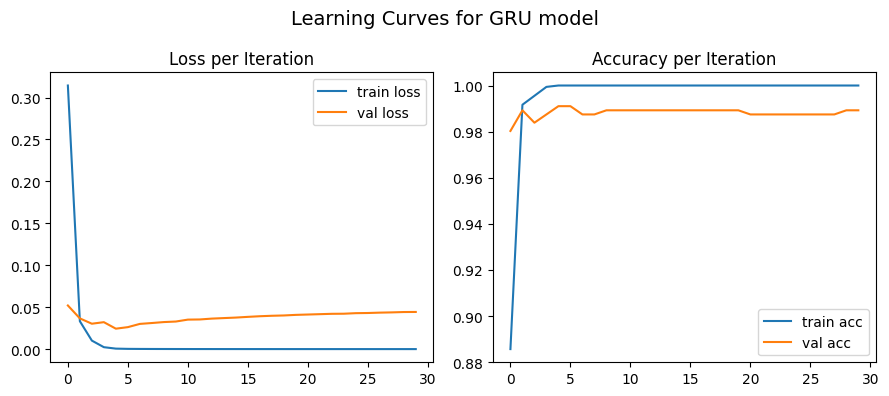

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

# Plot loss per iteration on the first subplot (index 0)
ax[0].plot(r.history['loss'], label='train loss')
ax[0].plot(r.history['val_loss'], label='val loss')
ax[0].set_title('Loss per Iteration')
ax[0].legend()

# Plot accuracy per iteration on the second subplot (index 1)
ax[1].plot(r.history['accuracy'], label='train acc')
ax[1].plot(r.history['val_accuracy'], label='val acc')
ax[1].set_title('Accuracy per Iteration')
ax[1].legend()

fig.suptitle('Learning Curves for GRU model', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

One thing I immediately noticed is that GRU model reached the convergence even faster than the LSTM and ANN models. This must be due to the Bidirectional layer incorporated.

In [89]:
P_train = ((GRU_.predict(data_train) > 0) * 1.0).flatten()
P_val = ((GRU_.predict(data_val) > 0) * 1.0).flatten()
P_test = ((GRU_.predict(data_test) > 0) * 1.0).flatten()


print("Train F1:", f1_score(Y_train, P_train))
print("Val F1:", f1_score(Y_val, P_val))
print("Test F1:", f1_score(Y_test, P_test))

18/18 [==============================] - 0s 9ms/step
Train F1: 1.0
Val F1: 0.9603729603729603
Test F1: 0.96875


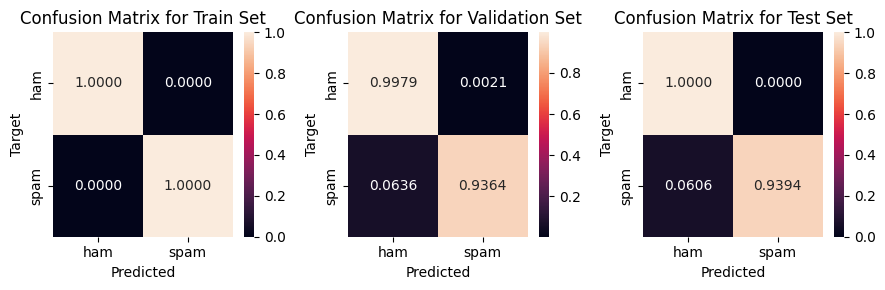

In [90]:
cm_train = confusion_matrix(Y_train, P_train, normalize='true')
cm_val = confusion_matrix(Y_val, P_val, normalize='true')
cm_test = confusion_matrix(Y_test, P_test, normalize='true')

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')
plot_cm(axes[2], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

- Interestingly, the GRU model performs better than LSTM (0.931) but still worse than the ANN (0.95) in the correct identification of spam messages in the validation set with a false negative rate of 6%.  
- On the other hand, it achieves a recall perforamce only superior to the LSTM (0.91) on the test set.

In [92]:
GRU_.save('GRU_.h5')

Notice LSTM & GRU models did not dramatically outperform the classic ANN models. This is mostly because this classification task is not a very complex one and the ANN already achieved quite a good performance.

## PART 3 : PERFORMANCE COMPARISON AND MODEL SELECTION

One thing I noticed on the performances of the models is that some might be performing better on the validation set whereas the others on the test set.

Therefore, in the code below, I will perform 50 different random splits on a combination of validation and test dataset. Yet, I won't train models again from scratch. Instead, I will collect the performances of these 4 models with already trained weights each time on a different test set.

In [102]:
models = {model_1 : 'Simple ANN - Tfidf',
          model_2 : 'Complex ANN - Word Embeddings',
          LSTM_: 'LSTM',
          GRU_ : 'Bidirectional GRU'}

model_performance = {}

model_performance['model_name'] = []
model_performance['accuracy'] = []
model_performance['f1'] = []
model_performance['precision'] = []
model_performance['recall'] = []

df_val_test = pd.Series(df_val.tolist() + df_test.tolist())
Y_val_test = pd.Series(Y_val.tolist() + Y_test.tolist())

for model in models.keys():

  for i in range(50):
    #looping over 5 different splits so that we will shuffle the test sets

    df_train, df_test,Y_train, Y_test = train_test_split(df_val_test, Y_val_test, test_size=0.33)

    if model == model_1:
      X_test = vectorizer.transform(df_test).toarray()
      P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

    else:
      sequences_test = tokenizer.texts_to_sequences(df_test)
      data_test = pad_sequences(sequences_test, maxlen=T)
      P_test = ((model.predict(data_test) > 0) * 1.0).flatten()


    model_performance['model_name'].append(models[model])
    model_performance['accuracy'].append(accuracy_score(Y_test, P_test))
    model_performance['f1'].append(f1_score(Y_test, P_test))
    model_performance['precision'].append(precision_score(Y_test, P_test))
    model_performance['recall'].append(recall_score(Y_test, P_test))




23/23 [==============================] - 0s 7ms/step


In [103]:
model_performance = pd.DataFrame(model_performance)
model_performance.head()

,model_name,accuracy,f1,precision,recall
0,Simple ANN - Tfidf,0.980848,0.933962,0.990000,0.883929
1,Simple ANN - Tfidf,0.987688,0.951351,0.988764,0.916667
2,Simple ANN - Tfidf,0.983584,0.934066,0.988372,0.885417
3,Simple ANN - Tfidf,0.990424,0.964467,1.000000,0.931373
4,Simple ANN - Tfidf,0.986320,0.945652,1.000000,0.896907


In [104]:
model_performance.shape

(200, 5)

The graph below will allow us to compare the average performance for 4 neural network we trained for accuracy, f1, precision and recall metrics across 10 diffrent test sets.

The error bars will show the standard deviation from the mean.

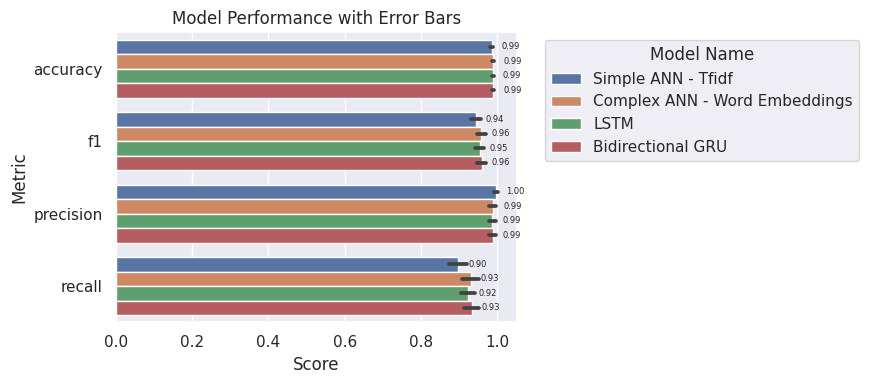

In [106]:
plt.figure(figsize=(9, 4))


melted_df = model_performance.melt(id_vars='model_name', var_name='score')
sns.set_theme()
sns.set_palette('deep')
ax = sns.barplot(data=melted_df, x='value', y='score', hue='model_name', ci='sd', dodge=True)

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'),
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='center', va='center',
                xytext=(14, 0),
                textcoords='offset points',
                fontsize=6)

plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('Model Performance with Error Bars')
plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

After testing on different random samples, we can see that:
- all 4 models achieves in average similar and high level of accuracy and precision scores that are near 0.99. There is not much variation in their accuracy performance across different samples.
- the simple ANN model falls clearly behind the other 3 in terms of f1 and recall scores, while outperforming all of them in the precision score. This implies us that the model is probably biased towards the dominant, in our case 'ham' class, and it tends to overpredict ham label.
- Recall is the metric that displays the largest variation for all 4 models.
- With the average performances as well as the degree of variation taken into account, GRU model seems to have a better performance than the rest on f1 and recall scores without a significant drop in precision.

So among these 4 models, Bidirectional GRU seem as the optimal choice.

##  PART 4: TRANSFER LEARNING

As a bonus model, I will check the performance of the pre-trained language models for this task.
- First: I will try out a [model](https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection?text=Camera+-+You+are+awarded+a+SiPix+Digital+Camera%21+call+09061221066+fromm+landline.+Delivery+within+28+days.) from HuggingFace trained specifically for spam detection task without any fine-tuning of the model on our data.
- Then: I'll import the custom BERT model and fine-tune its final layers to adjust the model parameters to our dataset and see its performace.

In [107]:
df = df.drop("v1",axis=1)
df = df.rename(columns={'v2': 'sentence', 'target': 'label'})
df.head()

,sentence,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


#### Attention :
Note that I am performing a new train-val-test split because this time I would like to keep sentences and labels together and convert them into DatasetDict objects with load_dataset function in order to be able to use transformer models on them. However, I am still keeping the random seed for the splits same (123), therefore, I will be dealing with the same train, validation and test sets, and hence will be comparing the model performances to the performances in PART 2.

In [108]:
df_train_val, df_test = train_test_split(df, test_size = 0.1, random_state = 123)
print("Size of the train&validation set is", df_train_val.shape[0])
print("Size of the test set is", df_test.shape[0])

Size of the train&validation set is 5014
Size of the test set is 558


In [109]:
df_train_val.to_csv('data_train_val.csv', index=None)
df_test.to_csv('data_test.csv',index=None)

In [110]:
raw_dataset = load_dataset('csv', data_files='data_train_val.csv')
final_test_dataset = load_dataset('csv', data_files='data_test.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [111]:
split = raw_dataset['train'].train_test_split(test_size=0.33, seed=123)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3359
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 1655
    })
})

### Transfer Learning without any Finetuning

In [112]:
pipe = pipeline("text-classification", model="mrm8488/bert-tiny-finetuned-sms-spam-detection")

In [113]:
P_val = pipe(split['test']['sentence'])
P_test = pipe(final_test_dataset['train']['sentence'])

Let's check what the output looks like:

In [114]:
P_test[:5]

[{'label': 'LABEL_0', 'score': 0.9370297789573669},
 {'label': 'LABEL_1', 'score': 0.9010783433914185},
 {'label': 'LABEL_0', 'score': 0.9329655766487122},
 {'label': 'LABEL_1', 'score': 0.9108092784881592},
 {'label': 'LABEL_0', 'score': 0.9382741451263428}]

The LABEL_1 corresponds to the category spam and LABEL_0 corresponds to the category ham. For more information on the model, again feel free to check its huggingface documentation [page](https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection)

In [115]:
def get_label(d):
  return int(d['label'].split('_')[1])

P_val = [get_label(d) for d in P_val]
P_test = [get_label(d) for d in P_test]

In [118]:
print("validation set accuracy:", accuracy_score(split['test']['label'], P_val))
print("validation set f1:", f1_score(split['test']['label'], P_val, average='macro'))


print("test set accuracy:", accuracy_score(final_test_dataset['train']['label'], P_test))
print("test set f1:", f1_score(final_test_dataset['train']['label'], P_test, average='macro'))

validation set accuracy: 0.9818731117824774
validation set f1: 0.9617082515825713
test set accuracy: 0.9874551971326165
test set f1: 0.9693221177634834


Without any finetuning, the pretrained model falls behind the average performance of all four trained neural networks in the accuracy score, yet it achieves comparable results in f1-score.

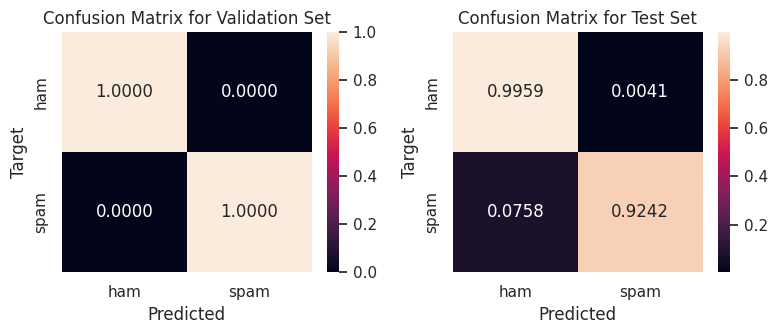

In [117]:
cm_val = confusion_matrix(split['test']['label'], P_val, normalize='true')
cm_test = confusion_matrix(final_test_dataset['train']['label'], P_test, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Validation Set')
plot_cm(axes[1], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

On this particular test set, the model failed to detect 7% of the spam messages.

### Finetuning a pretrained model

In [123]:
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch['sentence'], truncation=True)
    #include truncation but not padding
    #padding will be automatically done by trainer

tokenized_datasets = split.map(tokenize_fn, batched=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/3359 [00:00<?, ? examples/s]

Map:   0%|          | 0/1655 [00:00<?, ? examples/s]

In [124]:
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

The pretrained model contains over 100 million parameters ! Let's fine tune the parameters so that it will better to our dataset. Since the models are already pretrained and they start overfitting real fast, I limit the number of training epochs to 5.

In [126]:
training_args = TrainingArguments(
  output_dir='training_dir',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=5, #5 epochs
  per_device_train_batch_size=16,
  per_device_eval_batch_size=64,
)

In [127]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  prec = precision_score(labels, predictions)
  rec = recall_score(labels, predictions)
  return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

In [128]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [129]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.039170,0.990332,0.980232,0.957983,0.974359
2,No log,0.081502,0.985498,0.969253,0.981651,0.914530
3,0.050800,0.061524,0.990332,0.979948,0.973913,0.957265
4,0.050800,0.060140,0.990332,0.979875,0.978070,0.952991
5,0.001800,0.061129,0.990332,0.979875,0.978070,0.952991


TrainOutput(global_step=1050, training_loss=0.02504375528189398, metrics={'train_runtime': 557.1807, 'train_samples_per_second': 30.143, 'train_steps_per_second': 1.884, 'total_flos': 616379272171980.0, 'train_loss': 0.02504375528189398, 'epoch': 5.0})

- All 5 epoch achieved similar accuracies, whereas validation loss is the lowest at the 1st epoch.
- On the other hand, these is a mild trade-off between precision and recall scores among the 1st and 4th epoch.
- Since a customer would probably prefer failing to filter out a spam message rather than missing an important 'ham' message because it fell in the spam folder, I decided to go for the model with the higher precision, hence the model we trained at the 4th epoch, which has the second lowest validation loss.
- Let's find the corresponding checkpoint.

In [130]:
!ls training_dir

checkpoint-1050  checkpoint-210  checkpoint-420  checkpoint-630  checkpoint-840  runs


The fourth model's parameters is stored in the checkpoint-630.

In [131]:
finetunedmodel = pipeline('text-classification',
                      model='training_dir/checkpoint-630',
                      device=0)


In [132]:
final_test_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 558
    })
})

In [134]:
P_val = finetunedmodel(split['test']['sentence'])
P_test = finetunedmodel(final_test_dataset['train']['sentence'])

In [138]:
P_val = [get_label(d) for d in P_val]
P_test = [get_label(d) for d in P_test]

print("validation set accuracy:", accuracy_score(split['test']['label'], P_val))
print("validation set f1:", f1_score(split['test']['label'], P_val, average='macro'))

print("test set accuracy:", accuracy_score(final_test_dataset['train']['label'], P_test))
print("test set f1:", f1_score(final_test_dataset['train']['label'], P_test, average='macro'))

validation set accuracy: 0.9903323262839879
validation set f1: 0.9799476579349117
test set accuracy: 0.989247311827957
test set f1: 0.9738804805741925


The fine-tuned pre-trained model reached 0.99 accuracy score just like the neural networks we have trained and it seems to exceed their average performance of f1-score at least for these validation and test sets.

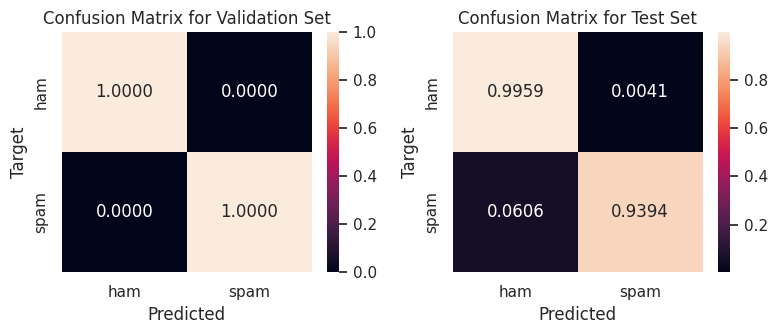

In [140]:
cm_val = confusion_matrix(split['test']['label'], P_val, normalize='true')
cm_test = confusion_matrix(final_test_dataset['train']['label'], P_test, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Validation Set')
plot_cm(axes[1], cm_test, title='Confusion Matrix for Test Set')

plt.tight_layout()
plt.show()

Even though I opted for the model with higher precision and sacrificed a degree of recall score in order not to miss out some important messages to the spam folder, the BERT-based pre-trained and fine-tuned model achieved a perfect score on this validation set (clearly outperformed the GRU on the same set in PART 2) and reached an equivalent performance on the test set.